In [1]:
library(tidyverse)
library(magrittr)
library(here)
library(furrr)
library(binom)

devtools::load_all(".")

plan(multiprocess)

options(future.globals.maxSize = 1500*1024^2)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──


✔ ggplot2 3.2.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0


── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



Attaching package: ‘magrittr’



The following object is masked from ‘package:purrr’:

    set_names



The following object is masked from ‘package:tidyr’:

    extract



here() starts at /mnt/expressions/mp/archaic-ychr


Loading required package: future


Loading ychr


# Lineage assignment (Mez2 vs A00 vs chimp)

In [2]:
highcov_all %<-% read_genotypes("mez2", "full", mindp = 3, maxdp = 0.98, nodmg = F, var_only = T)
highcov_nodmg %<-% read_genotypes("mez2", "full", mindp = 3, maxdp = 0.98, nodmg = T, var_only = T)

In [3]:
nrow(highcov_all)
nrow(highcov_nodmg)

[1] 220488

[1] 155326

Approximate length of the _Mezmaiskaya 2_ branch in years:

In [4]:
mez2_branch <- 370 - 44

In [24]:
#' Get positions at which individual 'ind_b' is derived
#' and a set of individuals in 'ancestral_ind' is ancestral (including
#' the reference.
get_derived <- function(ind_a, ind_b, gt, ancestral_ind, mindp) {
    capture <- ifelse(ind_a == "elsidron2", "lippold", "full")

    ind_gt <- here(paste0("data/vcf/", capture, "_", ind_a, ".vcf.gz")) %>%
        read_vcf(mindp = mindp, maxdp = 0.98) %>%
        filter(!is.na(!!sym(ind_a)))

    gt <- gt[, c("chrom", "pos", "REF", "ALT", ind_b, ancestral_ind)]
    ancestral_freq <- gt[, ancestral_ind] %>% rowMeans
    from_derived <- filter(gt, !!sym(ind_b) == 1, ancestral_freq == 0)

    joined_gt <- inner_join(from_derived, ind_gt, by = c("chrom", "pos", "REF")) %>%
        filter(complete.cases(.)) %>%
        select(-ALT.y) %>%
        rename(ALT = ALT.x)

    joined_gt
}

In [36]:
tmrca_df <- readRDS(here("data/rds/tmrca_df.rds"))
mez2_tmrca <- filter(tmrca_df, afr == "a00", arch == "mez2", sites == "all", dp == 3, filt == "filt50", capture == "full") %>% .$tmrca_new %>% mean
mez2_age <- 44000

In [51]:
estimate_split <- function(ind, gt, ancestral_ind,  mindp) {
  mez2_branch <- 370000

  mez2_derived <- get_derived(ind, "mez2", gt, ancestral_ind, mindp)

  counts <- ifelse(mez2_derived[[ind]] == 0, "ref", "alt") %>%
    factor(levels = c("ref", "alt")) %>%
    table %>%
    as.matrix %>%
    t %>%
    as.data.frame

  ## simulate confidence intervals by sampling REF/ALT counts from Poisson
  sample_refs <- rpois(1000, counts$ref)
  sample_alts <- rpois(1000, counts$alt)
  tmrca_ci <- quantile(
    sample_refs / (sample_refs + sample_alts) * (mez2_tmrca - mez2_age) + mez2_age,
    c(0.025, 0.975)
  )

  counts %>%
    mutate(
      ind = ind,
      prop_ref = ref / (ref + alt),
      tmrca = prop_ref * (mez2_tmrca - mez2_age) + mez2_age,
      tmrca_low = tmrca_ci[1],
      tmrca_high = tmrca_ci[2]
    ) %>%
    select(ind, everything())
}  

In [44]:
future_map_dfr(c("spy1", "elsidron2", paste0("mez2_dp", 1:10)), ~ estimate_split("spy1", highcov_all, c("a00", "chimp", "S_French_1"), mindp = 3))

ind,ref,alt,tmrca,tmrca_low,tmrca_high
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>
spy1,12,45,114304.4,80649.44,150862.7


In [62]:
future_map_dfr(c("spy1", "elsidron2", paste0("mez2_dp", 1:10)), ~ estimate_split(.x, highcov_all, c("a00", "chimp", "S_French_1"), mindp = 3))

ind,ref,alt,prop_ref,tmrca,tmrca_low,tmrca_high
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
spy1,12,45,0.2105263,114304.44,79958.84,152325.3
elsidron2,8,66,0.1081081,80102.28,57914.42,105660.8
mez2_dp1,0,43,0.0000000,44000.00,44000.00,44000.0
mez2_dp2,0,217,0.0000000,44000.00,44000.00,44000.0
mez2_dp3,0,416,0.0000000,44000.00,44000.00,44000.0
mez2_dp4,0,601,0.0000000,44000.00,44000.00,44000.0
mez2_dp5,0,709,0.0000000,44000.00,44000.00,44000.0
mez2_dp6,0,804,0.0000000,44000.00,44000.00,44000.0
mez2_dp7,0,880,0.0000000,44000.00,44000.00,44000.0


In [50]:
future_map_dfr(c("chag01", "chag41", "chag13", "chag07", "chag19"), ~ estimate_split(.x, highcov_all, c("a00", "chimp", "S_French_1"), mindp = 2))

ind,ref,alt,tmrca,tmrca_low,tmrca_high
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>
chag01,111,177,172708.4,154499.53,191502.7
chag41,146,549,114152.7,103773.98,124505.3
chag13,58,206,117366.9,100327.48,133717.8
chag07,46,209,104241.3,89183.63,120607.9
chag19,33,141,107334.6,88985.00,128544.0


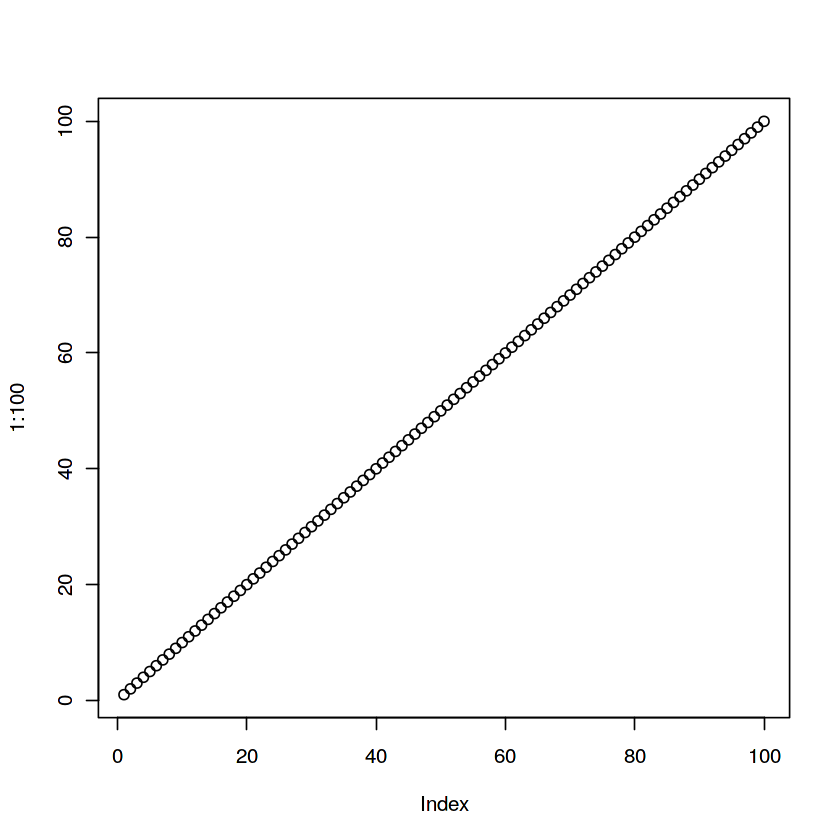

In [60]:
plot(1:100)